In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Conv2D
from tensorflow.keras import Model

2022-12-17 14:11:51.561757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 14:11:55.104504: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 14:12:11.559098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbifqfonsjwlqmr6qcnza2ezu/lib64:/dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbif

In [7]:
import orbit

ModuleNotFoundError: No module named 'orbit'

In [2]:
tf.__version__

'2.10.0'

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

2022-12-06 14:50:20.346894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 14:50:24.313936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [4]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [5]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [6]:
y_test.shape

(10000,)

In [7]:
x_test.shape

(10000, 28, 28, 1)

In [18]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

In [9]:
model = MyModel()

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [12]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [22]:
# @tf.function
# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     train_loss(loss)
#     train_accuracy(labels, predictions)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [24]:
@tf.function
def test_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=False)
        loss = loss_object(labels, predictions)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [25]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    print(
        f'Epoch {epoch+1},'
        f'Loss: {train_loss.result()*100},'
    )

Epoch 1,Loss: 4.381956577301025,
Epoch 2,Loss: 2.6250391006469727,
Epoch 3,Loss: 1.9404051303863525,
Epoch 4,Loss: 1.5955190658569336,
Epoch 5,Loss: 1.5239421129226685,


In [6]:
class Base(object):
    def __init__(self):
        print("Base created")
        
class ChildA(Base):
    def __init__(self):
        Base.__init__(self)
        
class ChildB(Base):
    def __init__(self):
        super(ChildB, self).__init__()

In [7]:
ChildA() 

Base created


In [8]:
ChildB()

Base created


In [1]:
import sys
sys.path.append(".")
# sys.path.append("./model/encoder/")
from config_yml import ExperimentOptions
import yaml
from model.encoder.axial_resnet_instances import AxialSWideRNet
from model.decoder.panoptic_deeplab import PanopticDeepLab
from model.builder import create_encoder
import tensorflow as tf
import numpy as np
from model.post_processor.post_processor_builder import get_post_processor
from data import dataset
from deeplab import DeepLab
from model.loss.loss_builder import DeepLabFamilyLoss
import orbit
from  trainer import distribution_utils

from trainer import trainer as trainer_lib
from trainer import runner_utils

from data.build_cell_data import _convert_dataset

%load_ext autoreload
%autoreload 2

2022-12-20 12:02:20.337504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 12:02:24.029149: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 12:02:39.536778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbifqfonsjwlqmr6qcnza2ezu/lib64:/dcsrsoft/spack/arolle/v1.0/spack/opt/spack/linux-rhel8-zen/gcc-8.4.1/gcc-10.4.0-7fjdev7tbif

In [2]:
with open("./configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
configs = ExperimentOptions(config)
datasets = dataset.MAP_NAME_TO_DATASET_INFO["cellfustion_panoptic"]

In [3]:
num_gpus=1
global_step = orbit.utils.create_global_step()
strategy = distribution_utils.create_strategy(num_gpus)
file_pattern = "./train*.tfrecord"
is_training = False

2022-12-20 12:03:08.172483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 12:03:13.216577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2022-12-20 12:03:13.218871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38224 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


In [4]:
with strategy.scope():
    model = DeepLab(configs, dataset.MAP_NAME_TO_DATASET_INFO["cellfustion_panoptic"])
    
    losses = DeepLabFamilyLoss(
                loss_options=configs.trainer_options.loss_options,
                num_classes=datasets.num_classes,
                ignore_label=datasets.ignore_label,
                ignore_depth=datasets.ignore_depth,
                thing_class_ids=datasets.class_has_instances_list)

    celldataset = runner_utils.create_dataset(configs.train_dataset_options,
        is_training=True,
        only_semantic_annotations=False)
    
    trainer = trainer_lib.Trainer(configs, model, losses, global_step)

00000 (None, None, 1)
1111 (None, None, 1)
2222 (256, 256, 1)
33333 (256, 256, 1)
00000 (None, None, 1)
1111 (None, None, 1)
2222 (256, 256, 1)
33333 (256, 256, 1)


In [5]:
controller = orbit.Controller(
strategy=strategy,
trainer=trainer,
evaluator=None,#evaluator,
global_step=global_step,
steps_per_loop=configs.trainer_options.steps_per_loop,
# checkpoint_manager=checkpoint_manager,
# summary_interval=configs.trainer_options.save_summaries_steps,
# summary_dir=os.path.join(self.model_dir, 'train'),
# eval_summary_dir=os.path.join(self.model_dir, 'eval')
)

In [6]:
result = controller.train(
    steps=10,
)

train | step:      0 | training until step 10...
create training loop!
self._train_iter is None
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f4184645520> tf.Tensor(2, shape=(), dtype=int32)


2022-12-20 12:06:18.019679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-20 12:06:26.054271: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 12:06:26.431118: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


train | step:      2 | steps/sec:    0.0 | output: 
    {'learning_rate': 7.4997755e-05,
     'losses/train_center_loss': 24.546997,
     'losses/train_regression_loss': 0.16354546,
     'losses/train_semantic_loss': 1.8406951,
     'losses/train_total_loss': 26.551239}
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f4184645520> tf.Tensor(2, shape=(), dtype=int32)
train | step:      4 | steps/sec:    0.4 | output: 
    {'learning_rate': 7.499551e-05,
     'losses/train_center_loss': 20.495754,
     'losses/train_regression_loss': 0.16606274,
     'losses/train_semantic_loss': 1.8166419,
     'losses/train_total_loss': 22.478462}
run _train_iter, numsteps: <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7f4184645520> tf.Tensor(2, shape=(), dtype=int32)
train | step:      6 | steps/sec:    0.4 | output: 
    {'learning_rate': 7.499325e-05,
     'losses/train_center_loss': 17.278046,
     'losses/train_regression

In [140]:
_convert_dataset("../../data/set6/", "train", "./tf/", True)

98
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_01_00.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_02_03.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_03_01.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_04_04.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_05_05.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_06_01.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_07_07.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_08_05.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_09_01.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_10_04.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_11_04.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_12_06.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_13_01.png
max: 1.0
../../data/set6/images/train/1_100_2x2/3306_REF_DIC_14_11.png
max: 1.0
../

max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_09.png
max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_10.png
max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_11.png
max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_12.png
max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_13.png


max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_14.png
max: 1.0
../../data/set6/images/train/2_100_2x2_c/REF_16.png
max: 1.0
../../data/set6/images/train/3_100_1x1/100x_bin1x1_2040x2040_DV_WT_01.png
max: 1.0
../../data/set6/images/train/3_100_1x1/100x_bin1x1_2040x2040_DV_WT_02.png
max: 1.0
../../data/set6/images/train/3_100_1x1/100x_bin1x1_2040x2040_DV_WT_03.png
max: 1.0
../../data/set6/images/train/3_100_1x1/100x_bin1x1_2040x2040_DV_WT_04.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_01.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_02.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_03.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_04.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_05.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_06.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_07.png
max: 1.0
../../data/set6/images/train/4_100_2x2/473_REF_TL_08.png
max: 1.0
../../dat

In [177]:
celldataset = runner_utils.create_dataset(configs.train_dataset_options,
    is_training=True,                      
    only_semantic_annotations=False)

00000 (None, None, 1)
1111 (None, None, 1)
2222 (256, 256, 1)
33333 (256, 256, 1)


In [143]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.io import imread

In [178]:
for example in tfds.as_numpy(celldataset.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    gt = example["panoptic_gt"]
    ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape, gt.shape)

['image', 'semantic_gt', 'semantic_loss_weight', 'is_crowd_gt', 'panoptic_gt', 'center_loss_weight', 'regression_loss_weight', 'instance_center_gt', 'instance_regression_gt']
(32, 256, 256, 1) (32, 256, 256)


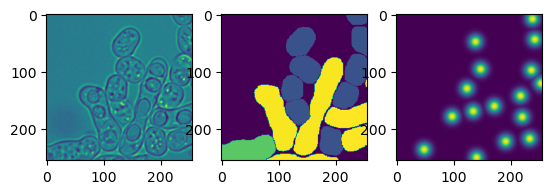

In [179]:
fig,axs = plt.subplots(1, 3)
axs[0].imshow(image[3,:,:,0])
axs[1].imshow(gt[3,:,:])
axs[2].imshow(ct[3,:,:])

In [180]:
image[0,:,:,0]

array([[0.05409241, 0.05378723, 0.05400085, ..., 0.05521393, 0.05522919,
        0.05535126],
       [0.05445099, 0.0546875 , 0.05448151, ..., 0.05517578, 0.05570221,
        0.05638885],
       [0.05453491, 0.05419922, 0.05400848, ..., 0.05471039, 0.05490875,
        0.05516052],
       ...,
       [0.05619812, 0.05576324, 0.05552673, ..., 0.06815338, 0.06591797,
        0.06254578],
       [0.05614471, 0.0557785 , 0.05593872, ..., 0.06630707, 0.06247711,
        0.05760956],
       [0.05609894, 0.0558548 , 0.05634308, ..., 0.06420135, 0.05893707,
        0.05280304]], dtype=float32)

In [163]:
tdata = tf.cast(image, tf.float32)

In [124]:
img = imread("../../data/set6/images/train/5_100_2x2/OD301_01.png")

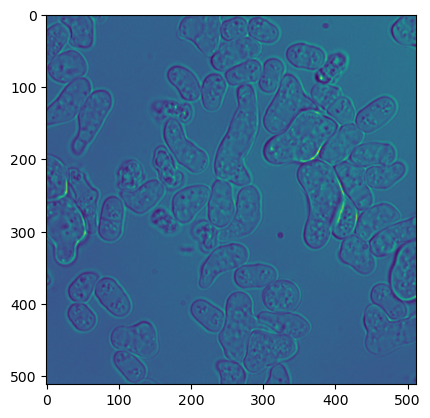

In [125]:
plt.imshow(img)

In [126]:
img = (img - np.min(img))/(np.max(img) - np.min(img))

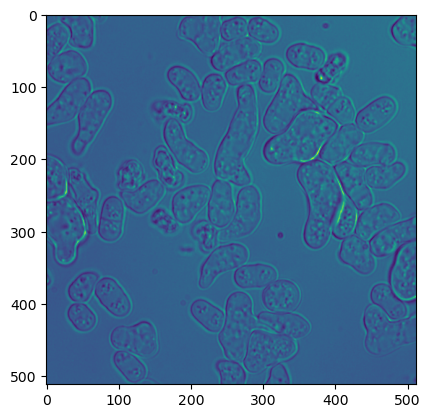

In [127]:
plt.imshow(img)